In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Position tracking KF
# state vector x = [x_k,v_k]
# cov matrix P is 2x2

class KF:

    def __init__(self, initial_x, initial_v, a_var):
        # Initial State
        self.x = np.array([initial_x, initial_v])
        # Initial Covariance
        self.P = np.eye(2)

        self.a_var = a_var

    @property
    def pos(self):
        return self.x[0]
    
    @property
    def vel(self):
        return self.x[1]
    
    @property
    def cov(self):
        return self.P
    
    @property
    def mean(self):
        return self.x

    def predict(self, dt):
        # x = F x
        # P = F P Ft + G Gt a

        F = np.array([[1, dt],[0, 1]])
        G = np.array([0.5*dt**2, dt]).reshape((2,1))

        self.x = F @ self.x

        self.P = F @ self.P @ F.T + G @ G.T * self.a_var 

    def update(self,meas_val, meas_var):

        # y = z - Hx
        # S = H P Ht + R
        # K = P Ht S^-1
        # x = x + K y
        # P = (I - K H) * P

        H = np.array([1,0]).reshape((1,2))
        z = np.array([meas_val])
        R = np.array([meas_var])
        
        y = z - H @ self.x

        S = H @ self.P @ H.T + R

        K = self.P @ H.T @ np.linalg.inv(S)

        self.x = self.x + K @ y
        self.P = (np.eye(2) - K @ H) @ self.P

In [27]:
kf = KF(initial_x = 1.0,initial_v = 2.0,a_var=0.5)

kf.predict(0.1)

print(np.linalg.det(kf.cov))

kf.update(3.0, 0.01)
print(kf.cov)


kf.predict(0.1)
kf.update(6.0,1.5)
print(kf.cov)


for _ in range(10):
    kf.predict(0.1)

print(np.linalg.det(kf.cov))



1.0050124999999999
[[9.90196199e-03 9.82831093e-04]
 [9.82831093e-04 9.95147118e-01]]
[[0.01979771 0.09941783]
 [0.09941783 0.99346972]]
0.0324679764234269


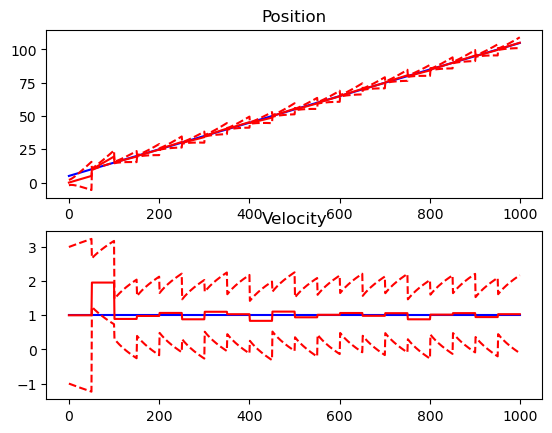

In [42]:
kf = KF(0.0, 1.0, 0.5)

def simulate(kf: KF, dt: float, n_steps: int, meas_freq:int, real_x0 : float, real_v0: float, meas_var: float):

    plt.figure()

    DT = dt
    NUM_STEPS = n_steps
    MEAS_EVERY_STEPS = meas_freq

    real_x = real_x0
    real_v = real_v0
    meas_var = meas_var

    mus = []
    covs = []
    real_xs = []
    real_vs = []

    for step in range(NUM_STEPS):

        if step > 1000:
            real_v *= 0.9

        covs.append(kf.cov)
        mus.append(kf.mean)
        real_xs.append(real_x)
        real_vs.append(real_v)

        real_x += DT*real_v

        kf.predict(DT)

        if step !=0 and step % MEAS_EVERY_STEPS == 0:
            kf.update(meas_val=real_x + np.random.randn() * np.sqrt(meas_var), meas_var=meas_var)

    plt.subplot(2,1,1)
    plt.title('Position')
    plt.plot(real_xs, 'b')
    plt.plot([mu[0] for mu in mus], 'r')
    plt.plot([mu[0] - 2*np.sqrt(cov[0,0]) for mu, cov in zip(mus, covs)], 'r--')
    plt.plot([mu[0] + 2*np.sqrt(cov[0,0]) for mu, cov in zip(mus, covs)], 'r--')

    plt.subplot(2,1,2)
    plt.title('Velocity')
    plt.plot(real_vs, 'b')
    plt.plot([mu[1] for mu in mus], 'r')
    plt.plot([mu[1] - 2*np.sqrt(cov[1,1]) for mu, cov in zip(mus, covs)], 'r--')
    plt.plot([mu[1] + 2*np.sqrt(cov[1,1]) for mu, cov in zip(mus, covs)], 'r--')

    plt.show()

simulate(kf, 0.1, 1000, 50, 5.0, 1.0, 0.3 ** 2)

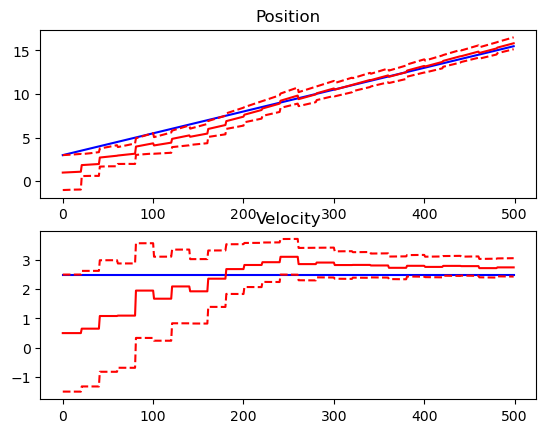

In [47]:
# Here you can define your own KF and simulate different scenarios

# KF Params
x0 = 1.0
v0 = 0.5
a_var = 0.8 ** 2

kf = KF(initial_x=x0, initial_v=v0, a_var=a_var)

# Simulation Params
dt = 0.01
n_steps = 500
meas_freq = 20
real_x0 = 3.0
real_v0 = 2.5
meas_var = 0.8 ** 2

simulate(kf, dt=dt, n_steps=n_steps, meas_freq=meas_freq, real_x0=real_x0, real_v0=real_v0, meas_var=meas_var)